# Capstone Project by Haowen 
## - A Recommend living place for relaxing travel in Toronto
### - Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1. Introduction: About the Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#analysis)
* [4. Results and Discussion](#results)
* [5. Conclusion](#conclusion)

## 1. Introduction: About the Problem <a name="introduction"></a>

Toronto can be a famous place for tourists from all over the world, and it has many tourist attractions in the old Toronto (East/ Central/ Downtown/ West Toronto). So when tourists want to have a visit to old Toronto, they have to choose a place to live. For tourists who want to experience the life of Toronto residents, variable venues can be necessary. This recommend system is designed to help tourists to choose the best place to live in Toronto. To some extent, better place means better quality of holiday.

For example, if the place tourists choose is far away from the recreational facilities, it means that they need to spend a lot of time for commuting. For people who do not want to live in the downtown, the bus station and subway station can be important so that they can guarantee them to go to other place more convenient.

The tourists should choose place to stay where is closest to much more different venues so that they can experience the life of local residents more conveniently. Restaurant and commuting station can be important because they are related to daily life.

## 2. Data <a name="data"></a>

We will need location data information about venues inside old Toronto borough, in fact, we have acquire borough data in Toronto ahead. And what I need to do is to filter the old Toronto borough data (East/ Central/ Downtown/ West Toronto). Then by using the Foursquare API, I got different venues' data in different neighborhoods in old Toronto borough. These data covers the location of the venues, the name of the venues and its neighborhoods. And the most important, the venues' Category and the venues' summary.

We will first filter the tourists place where is popular, because they are the most attractive to tourists, then we will use the K-Means algorithm to analyze the data so that we can find the best neighborhood for tourists to live, where can guarantee the most variable of venues in old Toronto. We will do research about the clusters and analyze the data we got.

### import libraries

In [129]:
# importing libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
# !conda install -c conda-forge beautifulsoup4 --yes
# from bs4 import BeautifulSoup
import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# import geopy.geocoders # convert an address into latitude and longitude values
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries are imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries are imported.


### import data we got about Toronto before and check it

In [130]:
# Loading the dataset which is about postal codes in Toronto
# This dataset was created in week 3. 
df_toronto = pd.read_csv('result.csv').iloc[:,1:]

print(df_toronto.shape)
df_toronto.head()

(103, 5)


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,['Scarborough'],"['Rouge', 'Malvern']",43.806686,-79.194353
1,M1C,['Scarborough'],"['Highland Creek', 'Rouge Hill', 'Port Union']",43.784535,-79.160497
2,M1E,['Scarborough'],"['Guildwood', 'Morningside', 'West Hill']",43.763573,-79.188711
3,M1G,['Scarborough'],['Woburn'],43.770992,-79.216917
4,M1H,['Scarborough'],['Cedarbrae'],43.773136,-79.239476


### Create a Map of Toronto City

In [131]:
# for the city Toronto, latitude and longtitude are manually extracted via google search
toronto_latitude = 43.6932; toronto_longitude = -79.3832
map_toronto = folium.Map(location = [toronto_latitude, toronto_longitude], zoom_start = 10.7)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    

map_toronto

In [4]:
df_toronto['Borough'].unique()

array(["['Scarborough']", "['North York']", "['East York']",
       "['East Toronto']", "['Central Toronto']", "['Downtown Toronto']",
       "['York']", "['West Toronto']", "['Mississauga']", "['Etobicoke']",
       '["Queen\'s Park"]'], dtype=object)

### Focusing on the "Old Toronto" Borough in Toronto (its neighborhoods)

### Create a Map of old Toronto and Its Neighbourhoods

In [132]:
# selecting only neighborhoods regarding to contains "Toronto" borough.
Nei_data = df_toronto[df_toronto['Borough'].str.contains('Toronto')]

toronto_latitude = 43.6932; toronto_longitude = -79.3832
map_toronto = folium.Map(location = [toronto_latitude, toronto_longitude], zoom_start = 11)

# add markers to map
for lat, lng, borough, neighborhood in zip(Nei_data['Latitude'], Nei_data['Longitude'], Nei_data['Borough'], Nei_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    

map_toronto

In [ ]:
label = ['Borough','Neighbourhood','Latitude','Longitude']
Nei_data = Nei_data[label]
Nei_data.head()

In [18]:
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
def foursquare_get(names, latitudes, longitudes, LIMIT = 250, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['reasons']['items'][0]['summary'],) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue summary']
    
    return(nearby_venues)

In [19]:
# @hiddel_cell
CLIENT_ID = 'MW5J5HH04KCYPNEBQVGSXP5L3H1RPMCZ4YMO1YXOJDA0TAKS' # your Foursquare ID
CLIENT_SECRET = 'M1O4YU2OIYB4MZQK2IGEGCXIAKYBHC1I4JDFNIOQCB4J45FS' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version

### Get Venues in the Neighborhoods inside 'Toronto' from Internet via Foursquare

In [20]:
print('Get different Venues inside Neighborhoods in "Toronto"')
Toronto_foursquare_dataset = foursquare_get(names = Nei_data['Neighbourhood'],
                                                latitudes = Nei_data['Latitude'],
                                                longitudes = Nei_data['Longitude'])

Get different Venues inside Neighborhoods in "Toronto"
['The Beaches']
['The Danforth West', 'Riverdale']
['The Beaches West', 'India Bazaar']
['Studio District']
['Lawrence Park']
['Davisville North']
['North Toronto West']
['Davisville']
['Moore Park', 'Summerhill East']
['Deer Park', 'Forest Hill SE', 'Rathnelly', 'South Hill', 'Summerhill West']
['Rosedale']
['Cabbagetown', 'St. James Town']
['Church and Wellesley']
['Harbourfront']
['Ryerson', 'Garden District']
['St. James Town']
['Berczy Park']
['Central Bay Street']
['Adelaide', 'King', 'Richmond']
['Harbourfront East', 'Toronto Islands', 'Union Station']
['Design Exchange', 'Toronto Dominion Centre']
['Commerce Court', 'Victoria Hotel']
['Roselawn']
['Forest Hill North', 'Forest Hill West']
['The Annex', 'North Midtown', 'Yorkville']
['Harbord', 'University of Toronto']
['Chinatown', 'Grange Park', 'Kensington Market']
['CN Tower', 'Bathurst Quay', 'Island airport', 'Harbourfront West', 'King and Spadina', 'Railway Lands', 'So

In [21]:
print(Toronto_foursquare_dataset.shape)
print(type(Toronto_foursquare_dataset))
Toronto_foursquare_dataset.head()

(1713, 8)
<class 'pandas.core.frame.DataFrame'>


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue summary
0,['The Beaches'],43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,This spot is popular
1,['The Beaches'],43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,This spot is popular
2,['The Beaches'],43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,This spot is popular
3,['The Beaches'],43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood,This spot is popular
4,"['The Danforth West', 'Riverdale']",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,This spot is popular


### save the data so that we do not have to use the api for many times

In [12]:
Toronto_foursquare_dataset.groupby('Neighbourhood')

In [13]:
Toronto_foursquare_dataset.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,['The Beaches'],43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,['The Beaches'],43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,['The Beaches'],43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,['The Beaches'],43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,['The Beaches'],43.676357,-79.293031,Seaspray Restaurant,43.678888,-79.298167,Asian Restaurant


In [22]:
Toronto_foursquare_dataset.to_csv('Toronto_final_data.csv')

In [7]:
import pandas as pd
Toronto_data = pd.read_csv('Toronto_final_data.csv').iloc[:,1:]

#### we only focus on venue data that is popular among people

In [8]:
Toronto_data = Toronto_data[Toronto_data['Venue summary'].str.contains('popular')]

In [9]:
Toronto_data.count()

Neighbourhood             1713
Neighborhood Latitude     1713
Neighborhood Longitude    1713
Venue                     1713
Venue Latitude            1713
Venue Longitude           1713
Venue Category            1713
Venue summary             1713
dtype: int64

## 3. Methodology <a name="analysis"></a>

### Some Summary Information about Neighborhoods inside old Toronto

#### 3.1 The top 10 Neibourhood which has the most Venues

The top 10 Neibourhood which has the most Venues:


,Num of Venues
Neighbourhood,
"['Adelaide', 'King', 'Richmond']",100
"['First Canadian Place', 'Underground city']",100
"['Design Exchange', 'Toronto Dominion Centre']",100
"['Harbourfront East', 'Toronto Islands', 'Union Station']",100
['St. James Town'],100
"['Commerce Court', 'Victoria Hotel']",100
"['Ryerson', 'Garden District']",100
['Stn A PO Boxes 25 The Esplanade'],95
"['Chinatown', 'Grange Park', 'Kensington Market']",87


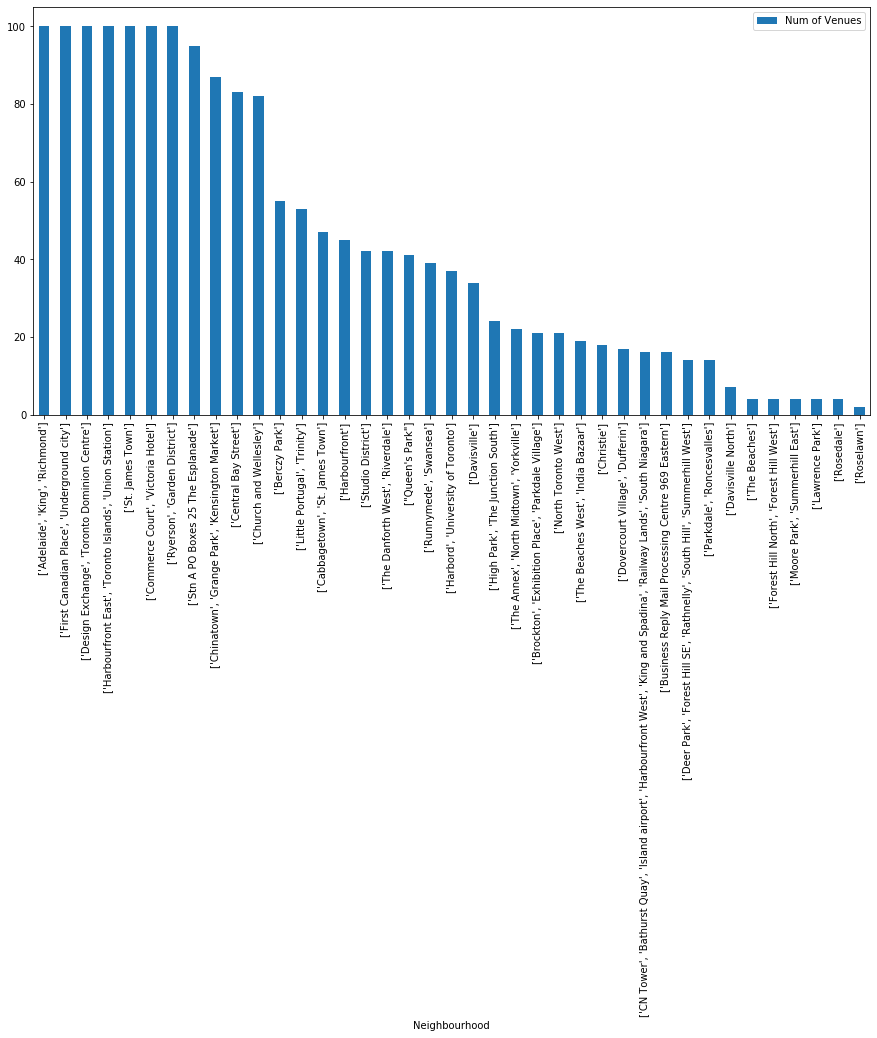

In [55]:
# neigh_list = list(scarborough_venues['Neighborhood'].unique())
# print('Number of Neighborhoods inside Scarborough:',)
# print(len(neigh_list))
# print('List of Neighborhoods inside Scarborough:')
# neigh_list

import matplotlib.pyplot as plt
%matplotlib inline

Neibor_data = pd.DataFrame(Toronto_data.groupby('Neighbourhood').count().iloc[:,0])
Neibor_data.columns = ['Num of Venues']
Neibor_data.sort_values(['Num of Venues'], ascending = False, inplace = True)
print('The top 10 Neibourhood which has the most Venues:')
Neibor_data.plot(kind = 'bar', figsize = (15,7.5))
Neibor_data.iloc[:10,:]

#### Neighborhoods which are at the top and the bottom are the most

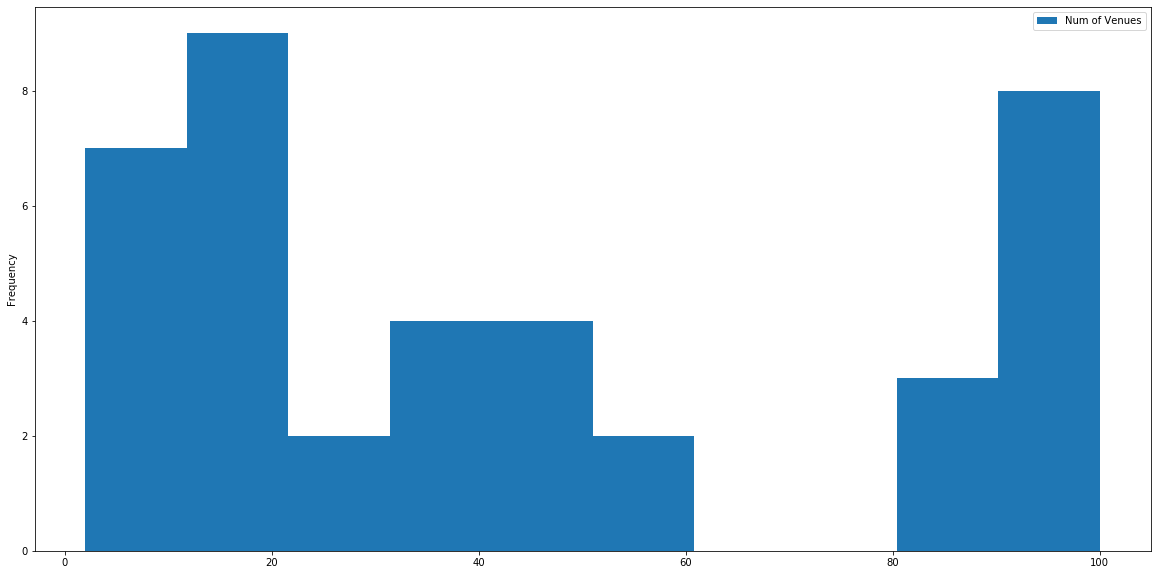

In [66]:
Neibor_data.plot(kind = 'hist', figsize = (20,10))

#### 3.2 The top 10 Neibourhood which has the most Venues Categories

The top 10 Neibourhood which have the most Venues Categories:


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Neighbourhood
['Ryerson', 'Garden District']                               64
['Adelaide', 'King', 'Richmond']                             62
['Harbourfront East', 'Toronto Islands', 'Union Station']    58
['St. James Town']                                           58
['Stn A PO Boxes 25 The Esplanade']                          57
['Church and Wellesley']                                     57
['Commerce Court', 'Victoria Hotel']                         53
['Design Exchange', 'Toronto Dominion Centre']               51
['First Canadian Place', 'Underground city']                 51
['Chinatown', 'Grange Park', 'Kensington Market']            51
Name: Num of Categories, dtype: int64

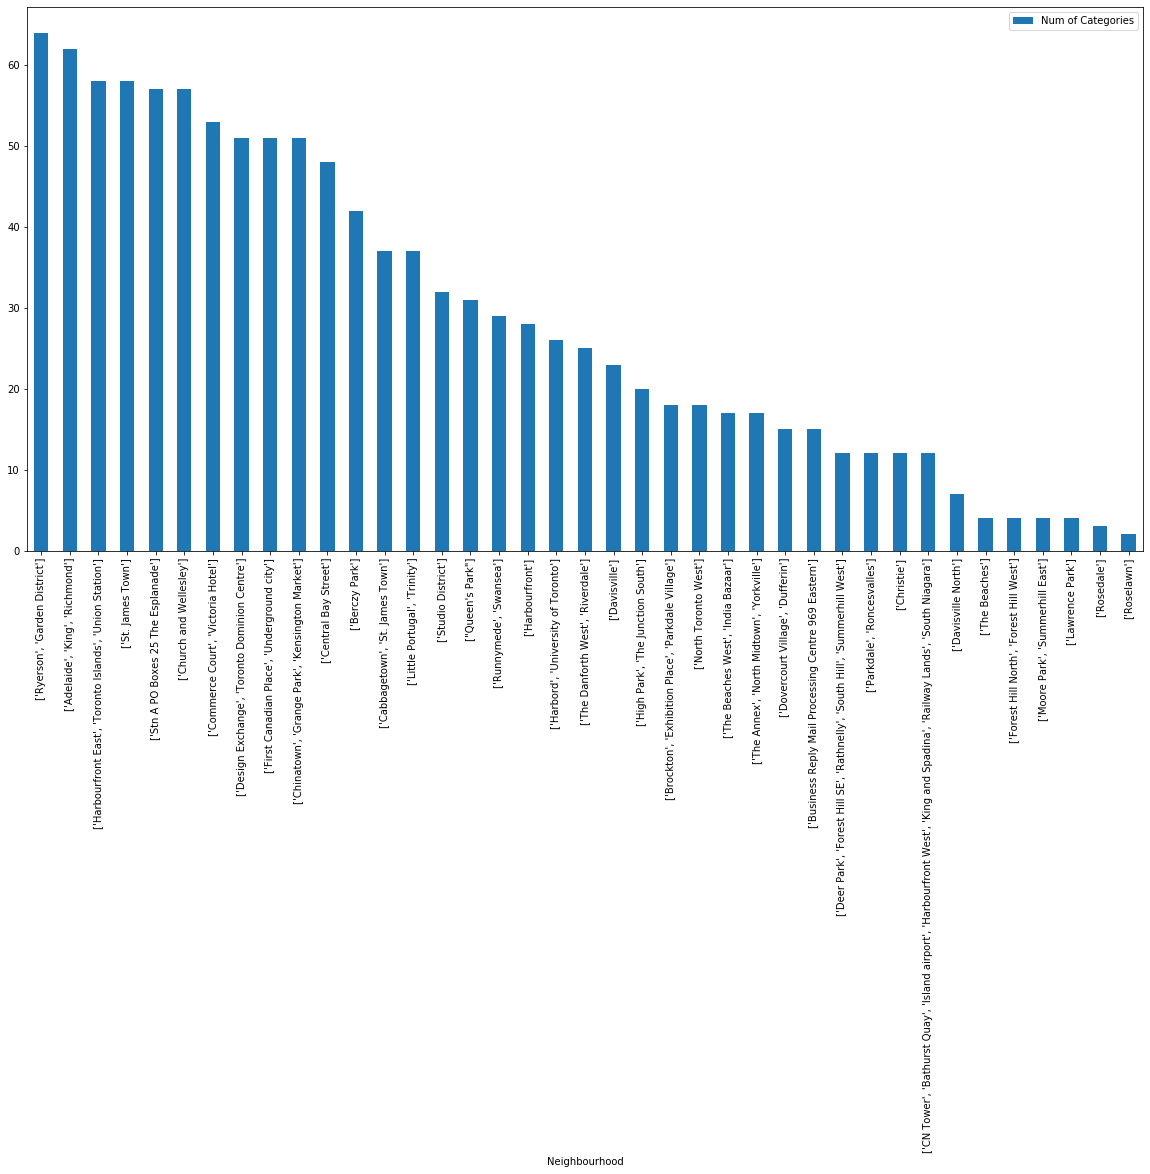

In [65]:
type_data = pd.DataFrame(Toronto_data.groupby('Neighbourhood')['Venue Category'].unique())
type_data.columns = ['categories']
# initialization
type_data['Num of Categories'] = 1
i = 0
for type in type_data['categories']:
    
    type_data['Num of Categories'][i] = len(type)
    i = i+1
type_data.sort_values('Num of Categories', ascending = False, inplace = True)
type_data.plot(y = 'Num of Categories', kind = 'bar', figsize = (20, 10))
print('The top 10 Neibourhood which have the most Venues Categories:')
type_data.iloc[:10, 1].head(10)

In [56]:
print('There are {} uniques categories.'.format(len(Toronto_data['Venue Category'].unique())))

print('Here is the list of different categories:')
list(Toronto_data['Venue Category'].unique())

There are 230 uniques categories.
Here is the list of different categories:


['Trail',
 'Health Food Store',
 'Pub',
 'Neighborhood',
 'Greek Restaurant',
 'Cosmetics Shop',
 'Italian Restaurant',
 'Ice Cream Shop',
 'Brewery',
 'Yoga Studio',
 'Fruit & Vegetable Store',
 'Dessert Shop',
 'Pizza Place',
 'Bookstore',
 'Restaurant',
 'Juice Bar',
 'Bubble Tea Shop',
 'Diner',
 'Spa',
 'Furniture / Home Store',
 'Grocery Store',
 'Coffee Shop',
 'Bakery',
 'Caribbean Restaurant',
 'Frozen Yogurt Shop',
 'American Restaurant',
 'Liquor Store',
 'Gym',
 'Burger Joint',
 'Fish & Chips Shop',
 'Park',
 'Sushi Restaurant',
 'Burrito Place',
 'Pet Store',
 'Steakhouse',
 'Fast Food Restaurant',
 'Movie Theater',
 'Sandwich Place',
 'Food & Drink Shop',
 'Fish Market',
 'Café',
 'Cheese Shop',
 'Gay Bar',
 'Seafood Restaurant',
 'Middle Eastern Restaurant',
 'Comfort Food Restaurant',
 'Stationery Store',
 'Thai Restaurant',
 'Wine Bar',
 'Coworking Space',
 'Bar',
 'Latin American Restaurant',
 'Gym / Fitness Center',
 'Gastropub',
 'Bank',
 'Convenience Store',
 'Clot

In [159]:
# Just for fun and deeper understanding
print(type(scarborough_venues[['Venue Category']]))

print(type(scarborough_venues['Venue Category']))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### One-hot Encoding the "categroies" Column into Every Unique Categorical Feature.

In [67]:
# one hot encoding
Toronto_onehot = pd.get_dummies(data = Toronto_data, drop_first  = False, 
                              prefix = "", prefix_sep = "", columns = ['Venue Category'])
Toronto_onehot.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue summary,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,['The Beaches'],43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,This spot is popular,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,['The Beaches'],43.676357

#### Grouping the data by Neighborhoods

In [68]:
Toronto_onehot = Toronto_onehot.groupby('Neighbourhood').sum()

In [76]:
Toronto_onehot = Toronto_onehot.iloc[:,4:]
print(Toronto_onehot.shape)

(39, 226)


#### The dataset is ready for machine learning algorithm

In [77]:
Toronto_onehot.head()

,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"[""Queen's Park""]",0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,9,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
"['Adelaide', 'King', 'Richmond']",0,0,0,

#### 3.3 Run k-means to Cluster Neighborhoods into 6 Clusters

Because 6 Neighborhoods has the same most Venues Categories, we cluster it into 6 Clusters

In [78]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# run k-means clustering
kmeans = KMeans(n_clusters = 6, random_state = 0).fit(Toronto_onehot)

#### Showing Centers of Each Cluster

In [83]:
result_df = pd.DataFrame(kmeans.cluster_centers_)
result_df.columns = Toronto_onehot.columns
result_df.index = ['C1','C2','C3','C4','C5','C6']
result_df['Total Sum'] = result_df.sum(axis = 1)
result_df.sort_values(['Total Sum'], ascending = False, inplace = True)
result_df

,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Total Sum
C5,0.000000e+00,0.000000e+00,0.000000e+00,2.500000,0.000000,0.00,1.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.500000,0.000000,3.000000,0.000000e+00,2.500000e-01,0.000000e+00,0.000000e+00,1.50,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,2.500000e-01,1.250000,0.000000,0.000000e+00,7.500000e-01,2.250000,0.250000,0.000000e+00,0.000000e+00,6.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.500000e-01,11.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.500000e+00,0.000000e+00,0.000000e+00,0.750000,0.000000e+00,2

## 4. Results and Discussion <a name="results"></a>

### 4.1 The top 3 Group types
### Best Group is C5;
###  Second Best Group is C2;
###  Third Best Group is C6;

### Inserting "kmeans.labels_" into the Original Scarborough DataFrame
Finding the Corresponding Group for Each Neighborhood.

In [89]:
Toronto_summary = pd.DataFrame([Toronto_onehot.index, kmeans.labels_+1]).T
Toronto_summary.columns = ['Neighborhood', 'Group']
Toronto_summary.set_index('Neighborhood', inplace = True)
Toronto_summary.sort_values('Group', ascending = False, inplace = True)
Toronto_summary

,Group
Neighborhood,
"['Chinatown', 'Grange Park', 'Kensington Market']",6
"['Adelaide', 'King', 'Richmond']",5
"['First Canadian Place', 'Underground city']",5
"['Design Exchange', 'Toronto Dominion Centre']",5
"['Commerce Court', 'Victoria Hotel']",5
"['Harbord', 'University of Toronto']",4
['Davisville'],4
"['The Annex', 'North Midtown', 'Yorkville']",4
['Studio District'],4


### 4.2 Analyze the 6 clusters

In fact, we can find that Coffee Shops and Cafe are popular in all 6 clusters, Hotel is easier to find both in C5 and C2. If tourists want to go to the park, they are more likely to consider C2, and for those who like Chinese food including dumplings, C6 can be a better choice. Seafood Restaurant can be easier to find in C5 and C2.
Overall speaking, C6 is more suitable for tourists to have dinner while C5 and C2 can be easy to find a hotel to stay.

-----------------------------
                        C5
Coffee Shop          11.00
Café                  6.50
Hotel                 4.25
Restaurant            4.00
Steakhouse            3.50
Bar                   3.00
Gastropub             2.75
Seafood Restaurant    2.75
American Restaurant   2.50
Bakery                2.50
-----------------------------
                        C2
Coffee Shop          11.50
Café                  4.25
Italian Restaurant    3.50
Restaurant            2.75
Hotel                 2.75
Bakery                2.25
Japanese Restaurant   2.00
Beer Bar              1.75
Seafood Restaurant    1.75
Park                  1.75
-----------------------------
                                C6
Café                           6.0
Vietnamese Restaurant          6.0
Bar                            5.0
Chinese Restaurant             5.0
Vegetarian / Vegan Restaurant  4.0
Dumpling Restaurant            4.0
Coffee Shop                    4.0
Mexican Restaurant             3.0
G

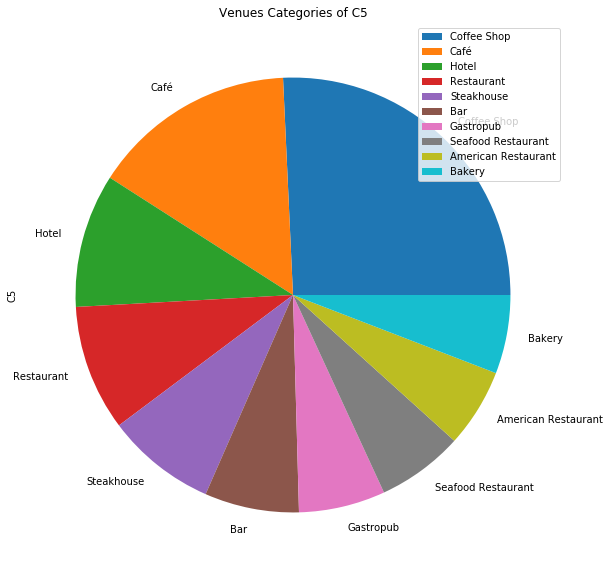

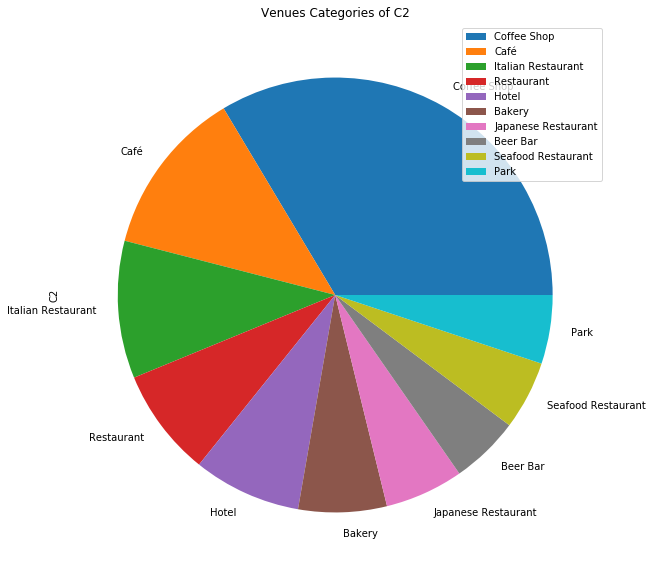

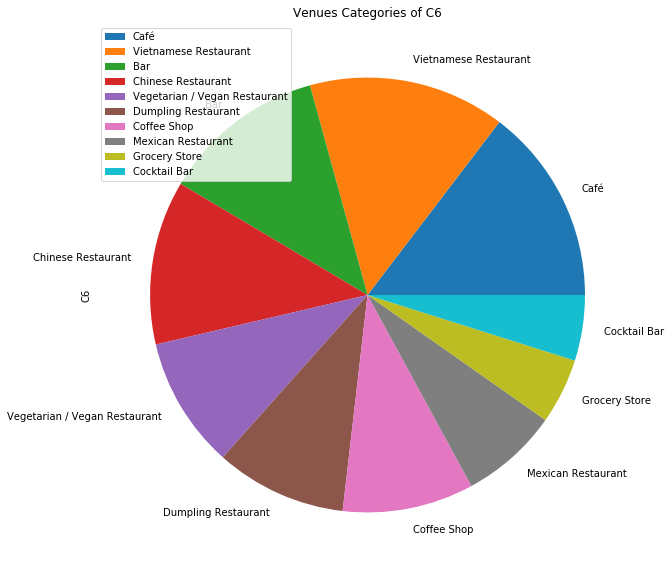

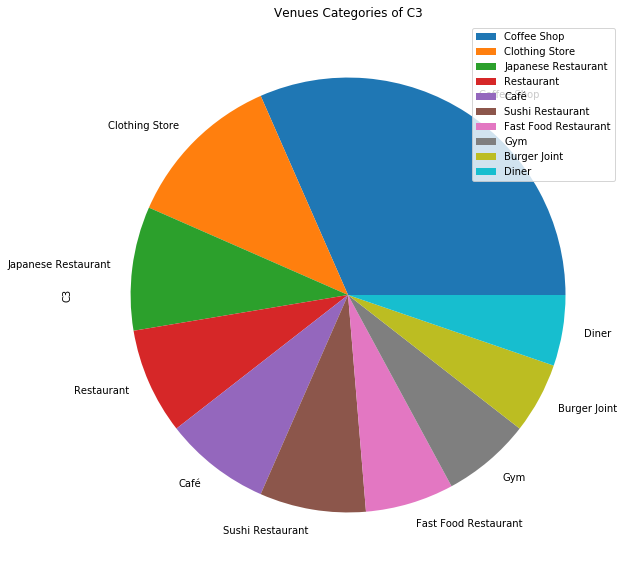

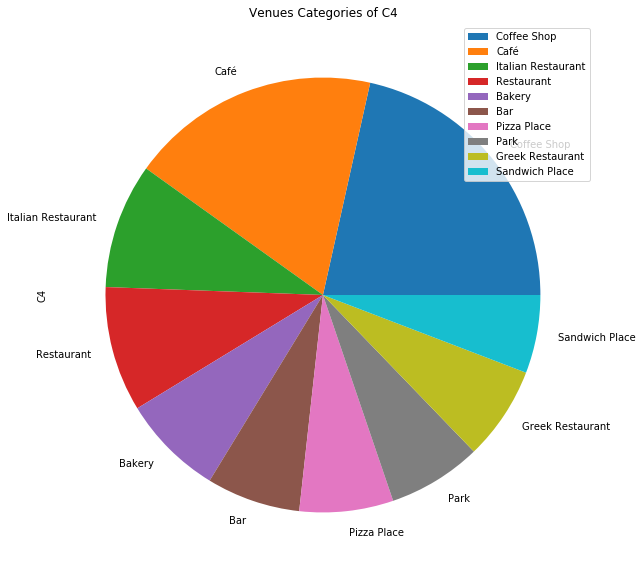

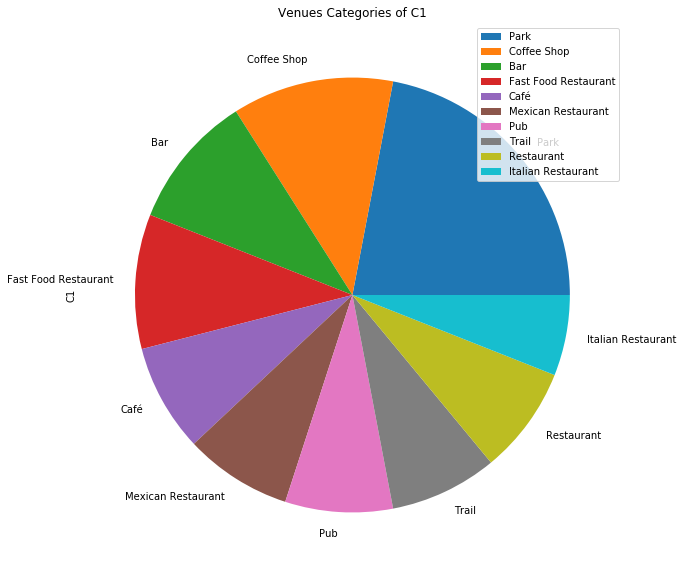

In [124]:
temp = result_df.drop(['Total Sum'], axis = 1)
discuss_1 = temp.T
for i in range(6):
    print('-----------------------------')
    picture = pd.DataFrame(discuss_1.iloc[:,i].sort_values(ascending = False).head(10))
    print(picture)
    picture.plot(y = picture.columns,kind = 'pie', figsize = (20,10))
    plt.title('Venues Categories of %s' %picture.columns[0])
    

## 5. Conclusion <a name="conclusion"></a>
## The Best Neighborhoods
### especially for those want to live in hotel and eat seafood restaurant

In [125]:
Toronto_summary[Toronto_summary['Group'] == 5]

,Group
Neighborhood,
"['Adelaide', 'King', 'Richmond']",5
"['First Canadian Place', 'Underground city']",5
"['Design Exchange', 'Toronto Dominion Centre']",5
"['Commerce Court', 'Victoria Hotel']",5


## Second Best Neighborhoods
### especially for those want to live in hotel and eat Japanese restaurant and go to park

In [126]:
Toronto_summary[Toronto_summary['Group'] == 2]

,Group
Neighborhood,
['Central Bay Street'],2
"['Harbourfront East', 'Toronto Islands', 'Union Station']",2
['Stn A PO Boxes 25 The Esplanade'],2
['St. James Town'],2


## Third Best Neighborhood

### especially for those want to eat Chinese Restaurant, and this Neighborhood is also popular with other food

In [127]:
Toronto_summary[Toronto_summary['Group'] == 6]

,Group
Neighborhood,
"['Chinatown', 'Grange Park', 'Kensington Market']",6


### Thank You So Much for Reading this Notebook. 
#### Haowen Wang - haowenw@gmail.com